In [1]:
#!/usr/bin/env python
# coding: utf-8
from __future__ import print_function
from collections import defaultdict
import pandas as pd
import time
import numpy as np
import pyspark
from utilities import *
from scipy.stats import pearsonr

In [2]:
sc = pyspark.SparkContext()

In [3]:
inh = 'ATV'
#vec_string = 'dist_vec'
vec_string = 'count_vec'

In [4]:
sparkfilename = get_shortest_path_folder(inh,vec_string)+"meanpysparkdata.csv"

In [5]:
header = 'path_id,inh_type,vec_type,root_mutation,path_length,path_type,fraction_above_inh_threshold,path_variance,path_mean'.split(",")
header = header[3:]

In [6]:
print(header)

['root_mutation', 'path_length', 'path_type', 'fraction_above_inh_threshold', 'path_variance', 'path_mean']


In [7]:
c = {n:i for i,n in enumerate(header)}

In [8]:
data = sc.textFile(sparkfilename).map(lambda x:x.split(",")[3:])
print(data.count())

4173506


In [9]:
type_frac_var = data.map(lambda x:(x[c['path_type']], x[c['fraction_above_inh_threshold']], x[c['path_variance']]))

In [10]:
#type_frac_var.count()

In [11]:
type_frac_mean = data.map(lambda x:(x[c['path_type']], x[c['fraction_above_inh_threshold']], x[c['path_mean']]))

In [12]:
#type_frac_mean.count()

In [13]:
type_frac_var.take(10)

[('path_type', 'fraction_above_inh_threshold', 'path_variance'),
 ('spikes', '0.9742', '0.0'),
 ('spikes', '0.055', '0.0'),
 ('spikes', '0.9821', '8.7146'),
 ('gains', '0.9571', '0.0'),
 ('spikes', '0.0305', '0.0'),
 ('spikes', '0.9786', '0.0'),
 ('gains', '0.9559', '0.0'),
 ('spikes', '0.9735', '10.7234'),
 ('spikes', '0.0652', '0.0')]

In [14]:
def last_float(a):
    try:
        a = float(a)
        return True
    except:
        return False 

In [15]:
type_listfrac_listvar = type_frac_var.filter(lambda x:last_float(x[-1])).map(lambda x:(x[0],(float(x[1]),float(x[2])))).groupByKey().map(lambda x:(x[0],separate(list(x[1]))))
type_listfrac_listmean = type_frac_mean.filter(lambda x:last_float(x[-1])).map(lambda x:(x[0],(float(x[1]),float(x[2])))).groupByKey().map(lambda x:(x[0],separate(list(x[1]))))

In [16]:
viz_scatter_var = type_listfrac_listvar.collectAsMap()
viz_scatter_mean = type_listfrac_listmean.collectAsMap()

In [17]:
viz_scatter_var.keys(), viz_scatter_mean.keys()

(dict_keys(['spikes', 'gains', 'above', 'below', 'looses']),
 dict_keys(['spikes', 'gains', 'above', 'below', 'looses']))

In [18]:
def draw_scatter(x,y,ptsize):
    plt.scatter(x,y,s=ptsize, color = 'k')

In [19]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10, 10
keys = ['gains','looses','spikes']

In [20]:
plt.rcParams['figure.figsize'] = 10, 10

In [ ]:
spikes_frac,spikes_var = viz_scatter_var[keys[-1]]
max_spikes_var = max(spikes_var)
try:
    gains_frac, gains_var = viz_scatter_var[keys[0]]
    max_gains_var = max(gains_var)
except:
    max_gains_var = 0 
    gains_frac, gains_var = [],[]
try:
    looses_frac, looses_var = viz_scatter_var[keys[1]]
    max_looses_var = max(looses_var)
except: 
    max_looses_var = 0
    looses_frac, looses_var = [],[]
max_var = max(max_gains_var,max_looses_var, max_spikes_var)
plt.ylim([0,max_var])

In [ ]:
draw_scatter(spikes_frac,spikes_var,0.5)
plt.ylim([0,max_var])
plt.xlabel("Fraction above threshold",fontsize=15)
plt.ylabel("Variance",fontsize=15)
#plt.title(inh+" "+vec_string+" "+keys[-1],fontsize=20)
plt.show()

In [ ]:
print(get_figfile(inh,vec_string,keys[-1]).split("/")[-1])

In [ ]:
draw_scatter(gains_frac,gains_var,1)
plt.ylim([0,max_var])
plt.xlabel("Fraction above threshold",fontsize=15)
plt.ylabel("Variance",fontsize=15)
plt.title(inh+" "+vec_string+" "+keys[0],fontsize=20)

In [ ]:
print(get_figfile(inh,vec_string,keys[0]).split("/")[-1])

In [ ]:
draw_scatter(looses_frac,looses_var,1)
plt.ylim([0,max_var])
plt.xlabel("Fraction above threshold",fontsize=15)
plt.ylabel("Variance",fontsize=15)
plt.title(inh+" "+vec_string+" "+keys[1],fontsize=20)

(0, 100.0)

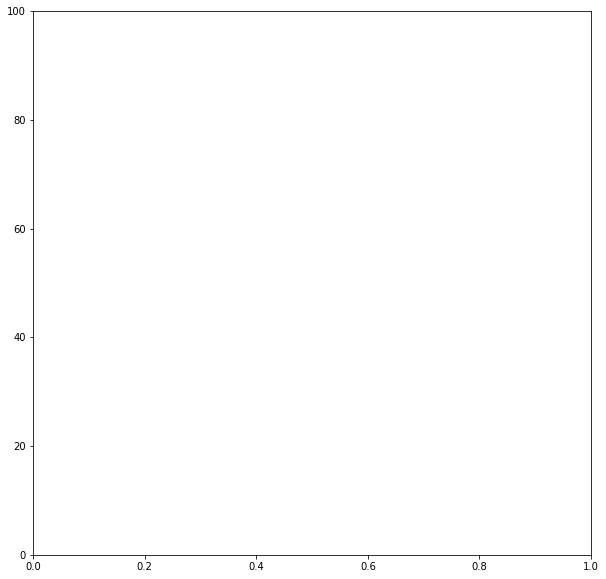

In [21]:
spikes_frac,spikes_mean = viz_scatter_mean[keys[-1]]
max_spikes_mean = max(spikes_mean)
try:
    gains_frac, gains_mean = viz_scatter_mean[keys[0]]
    max_gains_mean = max(gains_mean)
except:
    max_gains_mean = 0 
    gains_frac, gains_mean = [],[]
try:
    looses_frac, looses_mean = viz_scatter_mean[keys[1]]
    max_looses_mean = max(looses_mean)
except: 
    max_looses_mean = 0
    looses_frac, looses_mean = [],[]
max_mean = max(max_gains_mean,max_looses_mean, max_spikes_mean)
plt.ylim([0,max_mean])

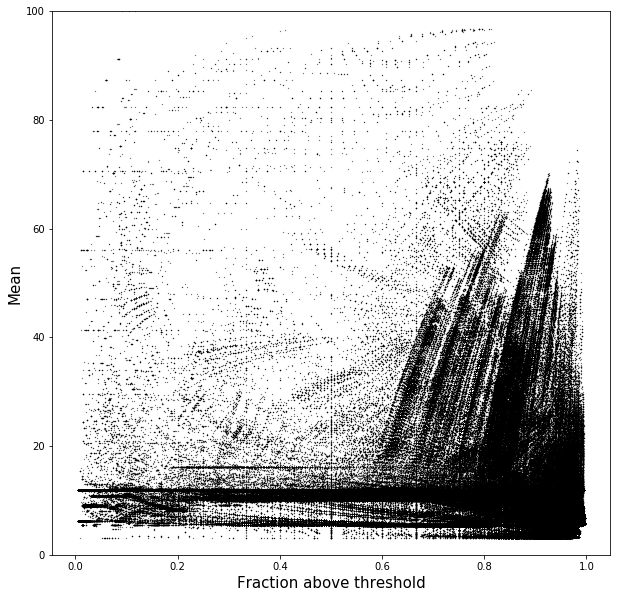

In [22]:
draw_scatter(spikes_frac,spikes_mean,0.05)
plt.ylim([0,max_mean])
plt.xlabel("Fraction above threshold",fontsize=15)
plt.ylabel("Mean",fontsize=15)
#plt.title(inh+" "+vec_string+" "+keys[-1],fontsize=20)
plt.show()

Text(0, 0.5, 'Mean')

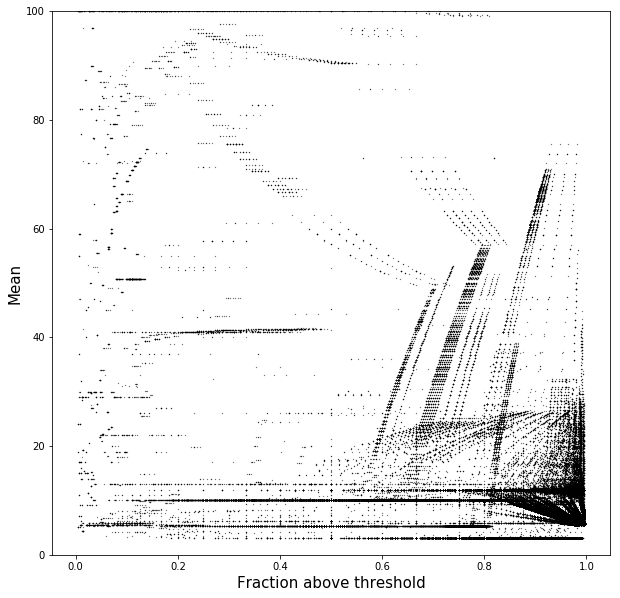

In [23]:
draw_scatter(gains_frac,gains_mean,0.05)
plt.ylim([0,max_mean])
plt.xlabel("Fraction above threshold",fontsize=15)
plt.ylabel("Mean",fontsize=15)
#plt.title(inh+" "+vec_string+" "+keys[0],fontsize=20)

Text(0, 0.5, 'Mean')

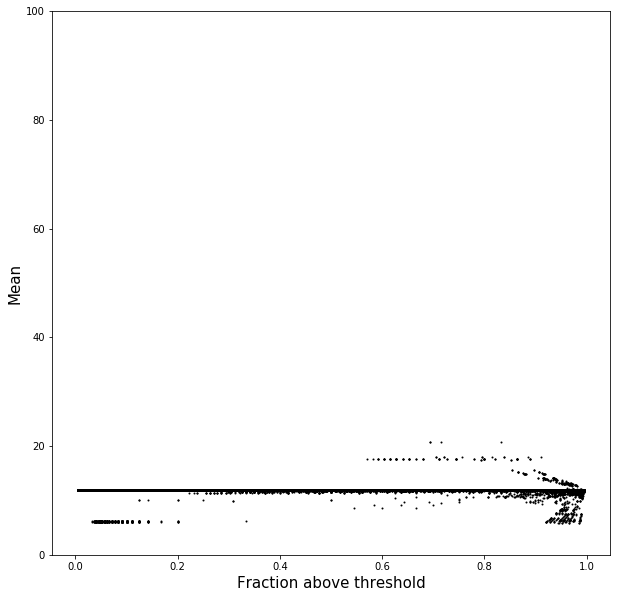

In [24]:
draw_scatter(looses_frac,looses_mean,1)
plt.ylim([0,max_mean])
plt.xlabel("Fraction above threshold",fontsize=15)
plt.ylabel("Mean",fontsize=15)
#plt.title(inh+" "+vec_string+" "+keys[1],fontsize=20)

In [ ]:
print(get_figfile(inh,vec_string,keys[1]).split("/")[-1])